# National Parks Visitation Analysis
## Clustering by Park Size and Season

This notebook analyzes national park visitation data by:
1. Clustering parks into Large, Medium, and Small based on total visitation
2. Analyzing seasonal patterns (Winter, Spring, Summer, Fall)
3. Visualizing visitation across all 12 categories


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)


## 1. Load and Prepare Data


In [3]:
# Load the data
df = pd.read_csv('Datasets/national_parks.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (34151, 35)

Columns: ['ParkName', 'UnitCode', 'ParkType', 'Region', 'State', 'Year', 'Month', 'RecreationVisits', 'NonRecreationVisits', 'RecreationHours', 'NonRecreationHours', 'ConcessionerLodging', 'ConcessionerCamping', 'TentCampers', 'RVCampers', 'Backcountry', 'NonRecreationOvernightStays', 'MiscellaneousOvernightStays', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'MiscellaneousOvernightStaysTotal']

First few rows:


/var/folders/y1/sdp6z2n512jfxp76fkhspjfc0000gn/T/ipykernel_78765/3013761827.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Datasets/national_parks.csv')


,ParkName,UnitCode,ParkType,Region,State,Year,Month,RecreationVisits,NonRecreationVisits,RecreationHours,...,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,MiscellaneousOvernightStaysTotal
0,Acadia NP,ACAD,National Park,Northeast,ME,1979,1,"6,011","15,252","37,446",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,Acadia NP,ACAD,National Park,Northeast,ME,1979,2,"5,243","13,776","17,661",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Acadia NP,ACAD,National Park,Northeast,ME,1979,3,"11,165","15,252","36,051",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Acadia NP,ACAD,National Park,Northeast,ME,1979,4,"219,351","37,657","1,334,058",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,Acadia NP,ACAD,National Park,Northeast,ME,1979,5,"339,416","50,616","2,088,588",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [4]:
# Clean the data - remove commas from numeric columns and convert to numeric
numeric_columns = ['RecreationVisits', 'NonRecreationVisits', 'RecreationHours', 'NonRecreationHours',
                   'ConcessionerLodging', 'ConcessionerCamping', 'TentCampers', 'RVCampers', 
                   'Backcountry', 'NonRecreationOvernightStays', 'MiscellaneousOvernightStays']

for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')

# Fill NaN values with 0 for visit counts
df['RecreationVisits'] = df['RecreationVisits'].fillna(0)
df['NonRecreationVisits'] = df['NonRecreationVisits'].fillna(0)

# Create total visits column
df['TotalVisits'] = df['RecreationVisits'] + df['NonRecreationVisits']

print(f"Data cleaned successfully!")
print(f"Date range: {df['Year'].min()} - {df['Year'].max()}")


Data cleaned successfully!
Date range: 1979 - 2024


## 2. Define Seasons


In [5]:
# Define seasons based on months
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Fall'

df['Season'] = df['Month'].apply(get_season)

print("Seasons assigned:")
print(df['Season'].value_counts().sort_index())


Seasons assigned:
Season
Fall      8538
Spring    8538
Summer    8538
Winter    8537
Name: count, dtype: int64


## 3. Cluster Parks by Size (Large, Medium, Small)


In [6]:
# Calculate total visitation per park across all years
park_totals = df.groupby('ParkName')['TotalVisits'].sum().reset_index()
park_totals.columns = ['ParkName', 'TotalVisitsAllTime']
park_totals = park_totals.sort_values('TotalVisitsAllTime', ascending=False)

print(f"Total number of parks: {len(park_totals)}")
print(f"\nTop 10 most visited parks:")
print(park_totals.head(10))


Total number of parks: 63

Top 10 most visited parks:
                    ParkName  TotalVisitsAllTime
26  Great Smoky Mountains NP           895608088
22           Grand Canyon NP           200411274
30            Hot Springs NP           182281349
60            Yellowstone NP           178095620
23            Grand Teton NP           174776122
46                Olympic NP           173106570
61               Yosemite NP           165777011
50         Rocky Mountain NP           149232416
0                  Acadia NP           145144435
51                Saguaro NP           133499258


In [7]:
# Cluster parks into 3 size categories using quantiles
# Large: Top 33%, Medium: Middle 33%, Small: Bottom 33%
park_totals['SizeCategory'] = pd.qcut(park_totals['TotalVisitsAllTime'], 
                                        q=3, 
                                        labels=['Small', 'Medium', 'Large'])

# Display the distribution
print("Park size distribution:")
print(park_totals['SizeCategory'].value_counts())

print("\nVisitation ranges by size category:")
for category in ['Small', 'Medium', 'Large']:
    subset = park_totals[park_totals['SizeCategory'] == category]['TotalVisitsAllTime']
    print(f"{category}: {subset.min():,.0f} - {subset.max():,.0f} total visits")


Park size distribution:
SizeCategory
Small     21
Medium    21
Large     21
Name: count, dtype: int64

Visitation ranges by size category:
Small: 321,697 - 19,273,729 total visits
Medium: 19,351,844 - 55,459,528 total visits
Large: 65,156,477 - 895,608,088 total visits


In [8]:
# Merge size category back to main dataframe
df = df.merge(park_totals[['ParkName', 'SizeCategory', 'TotalVisitsAllTime']], on='ParkName', how='left')

print(f"Size categories added to dataframe!")
print(f"\nSample of data with categories:")
df[['ParkName', 'Year', 'Month', 'Season', 'TotalVisits', 'SizeCategory']].head(15)


Size categories added to dataframe!

Sample of data with categories:


,ParkName,Year,Month,Season,TotalVisits,SizeCategory
0,Acadia NP,1979,1,Winter,21263,Large
1,Acadia NP,1979,2,Winter,19019,Large
2,Acadia NP,1979,3,Spring,26417,Large
3,Acadia NP,1979,4,Spring,257008,Large
4,Acadia NP,1979,5,Spring,390032,Large
5,Acadia NP,1979,6,Summer,613981,Large
6,Acadia NP,1979,7,Summer,424412,Large
7,Acadia NP,1979,8,Summer,516956,Large
8,Acadia NP,1979,9,Fall,354438,Large
9,Acadia NP,1979,10,Fall,333222,Large


## 4. Create 12 Categories (Size × Season)


In [9]:
# Create combined category
df['Category'] = df['SizeCategory'].astype(str) + ' - ' + df['Season']

# Calculate average visitation by category
category_visits = df.groupby(['SizeCategory', 'Season', 'Category']).agg({
    'TotalVisits': ['mean', 'sum', 'count'],
    'RecreationVisits': 'mean'
}).reset_index()

category_visits.columns = ['SizeCategory', 'Season', 'Category', 'AvgVisits', 'TotalVisits', 'Count', 'AvgRecVisits']

# Order categories logically
size_order = ['Large', 'Medium', 'Small']
season_order = ['Winter', 'Spring', 'Summer', 'Fall']

category_visits['SizeCategory'] = pd.Categorical(category_visits['SizeCategory'], categories=size_order, ordered=True)
category_visits['Season'] = pd.Categorical(category_visits['Season'], categories=season_order, ordered=True)
category_visits = category_visits.sort_values(['SizeCategory', 'Season'])

print("Average visitation by category:")
print(category_visits)


Average visitation by category:
    SizeCategory  Season         Category      AvgVisits  TotalVisits  Count  \
132        Large  Winter     Large - Fall            NaN            0      0   
133        Large  Winter   Large - Spring            NaN            0      0   
134        Large  Winter   Large - Summer            NaN            0      0   
135        Large  Winter   Large - Winter  143867.481021    416927960   2898   
136        Large  Winter    Medium - Fall            NaN            0      0   
..           ...     ...              ...            ...          ...    ...   
7          Small    Fall  Medium - Winter            NaN            0      0   
8          Small    Fall     Small - Fall   12072.177367     33282993   2757   
9          Small    Fall   Small - Spring            NaN            0      0   
10         Small    Fall   Small - Summer            NaN            0      0   
11         Small    Fall   Small - Winter            NaN            0      0   

     Av

/var/folders/y1/sdp6z2n512jfxp76fkhspjfc0000gn/T/ipykernel_78765/2625828778.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_visits = df.groupby(['SizeCategory', 'Season', 'Category']).agg({


## 5. Visualizations


### 5.1 Bar Chart - Average Visitation by Category


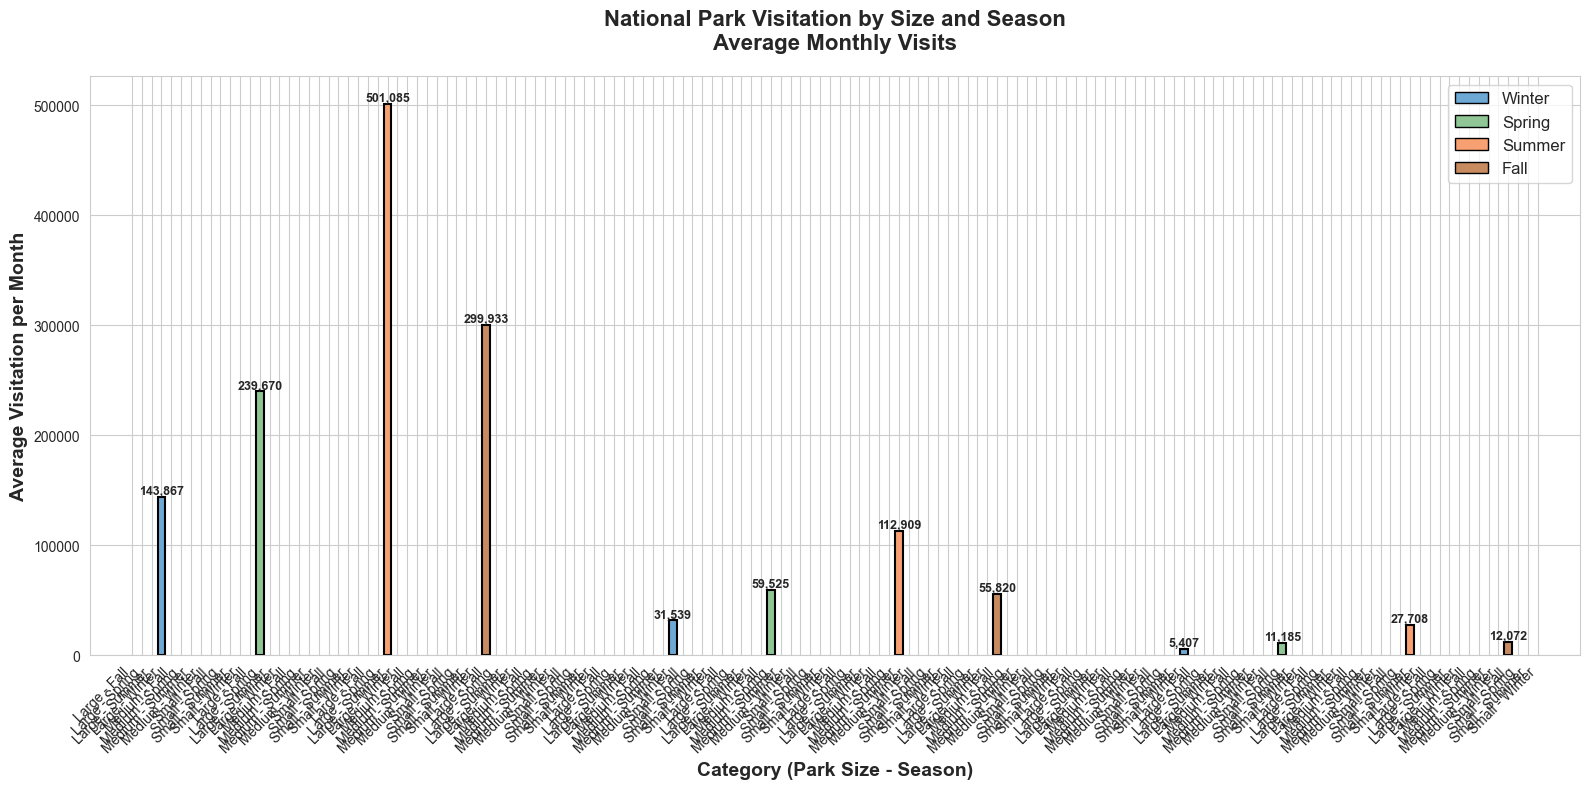

In [10]:
# Create a bar chart showing average visitation by category
fig, ax = plt.subplots(figsize=(16, 8))

# Define colors for each season
season_colors = {
    'Winter': '#6EA8D4',  # Blue
    'Spring': '#90C695',  # Green
    'Summer': '#F7A072',  # Orange
    'Fall': '#C88B5F'     # Brown
}

colors = [season_colors[season] for season in category_visits['Season']]

bars = ax.bar(range(len(category_visits)), category_visits['AvgVisits'], color=colors, edgecolor='black', linewidth=1.5)

# Customize the plot
ax.set_xlabel('Category (Park Size - Season)', fontsize=14, fontweight='bold')
ax.set_ylabel('Average Visitation per Month', fontsize=14, fontweight='bold')
ax.set_title('National Park Visitation by Size and Season\nAverage Monthly Visits', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(range(len(category_visits)))
ax.set_xticklabels(category_visits['Category'], rotation=45, ha='right')

# Add value labels on top of bars
for i, (bar, val) in enumerate(zip(bars, category_visits['AvgVisits'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:,.0f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add legend for seasons
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=season_colors[season], edgecolor='black', label=season) 
                   for season in season_order]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()


### 5.2 Heatmap - Visitation by Size and Season


In [11]:
# Create a pivot table for heatmap
pivot_data = category_visits.pivot(index='SizeCategory', columns='Season', values='AvgVisits')
pivot_data = pivot_data[season_order]  # Reorder columns

fig, ax = plt.subplots(figsize=(12, 6))

sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Average Monthly Visits'}, 
            linewidths=2, linecolor='white',
            ax=ax)

ax.set_title('National Park Visitation Heatmap\nAverage Monthly Visits by Size and Season', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Season', fontsize=14, fontweight='bold')
ax.set_ylabel('Park Size Category', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


ValueError: Index contains duplicate entries, cannot reshape

### 5.3 Grouped Bar Chart by Size


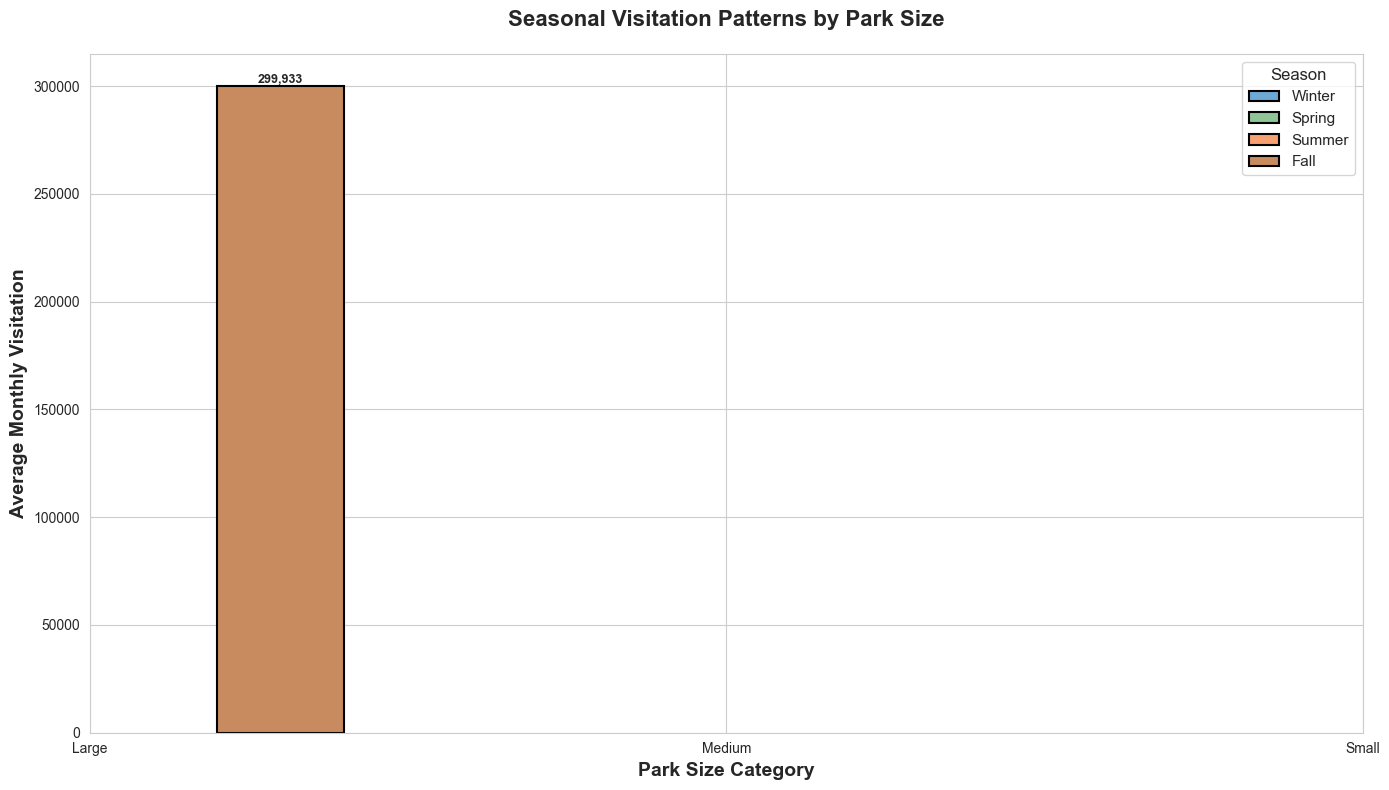

In [12]:
# Create grouped bar chart
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(size_order))
width = 0.2

for i, season in enumerate(season_order):
    season_data = category_visits[category_visits['Season'] == season]
    values = [season_data[season_data['SizeCategory'] == size]['AvgVisits'].values[0] 
              for size in size_order]
    offset = width * (i - 1.5)
    bars = ax.bar(x + offset, values, width, label=season, color=season_colors[season], 
                  edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,.0f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Park Size Category', fontsize=14, fontweight='bold')
ax.set_ylabel('Average Monthly Visitation', fontsize=14, fontweight='bold')
ax.set_title('Seasonal Visitation Patterns by Park Size', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(size_order)
ax.legend(title='Season', fontsize=11, title_fontsize=12)

plt.tight_layout()
plt.show()


### 5.4 Line Plot - Seasonal Trends by Park Size


ValueError: x and y must have same first dimension, but have shapes (4,) and (48,)

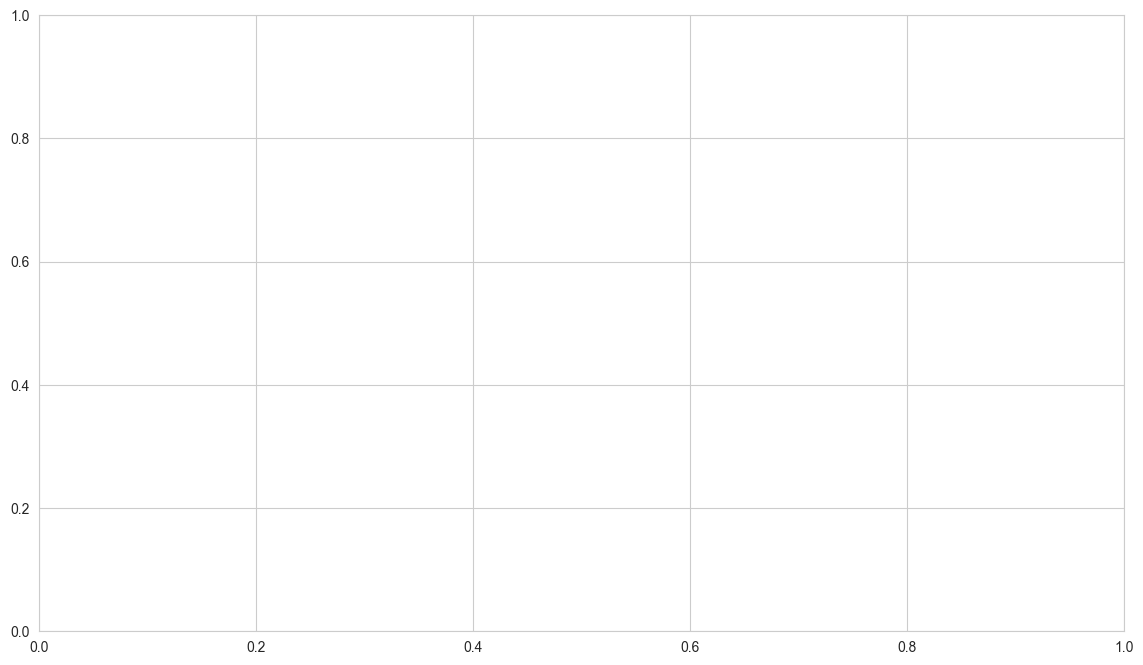

In [13]:
# Create line plot showing seasonal trends
fig, ax = plt.subplots(figsize=(14, 8))

size_colors = {'Large': '#E74C3C', 'Medium': '#3498DB', 'Small': '#2ECC71'}

for size in size_order:
    size_data = category_visits[category_visits['SizeCategory'] == size]
    ax.plot(range(len(season_order)), size_data['AvgVisits'].values, 
            marker='o', linewidth=3, markersize=12, label=f'{size} Parks',
            color=size_colors[size])
    
    # Add value labels
    for i, val in enumerate(size_data['AvgVisits'].values):
        ax.text(i, val, f'{val:,.0f}', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Season', fontsize=14, fontweight='bold')
ax.set_ylabel('Average Monthly Visitation', fontsize=14, fontweight='bold')
ax.set_title('Seasonal Visitation Trends Across Park Sizes', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(range(len(season_order)))
ax.set_xticklabels(season_order)
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 5.5 Box Plots - Distribution of Visits by Category


/var/folders/y1/sdp6z2n512jfxp76fkhspjfc0000gn/T/ipykernel_78765/3264157603.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(season_data, labels=season_order, patch_artist=True,
/var/folders/y1/sdp6z2n512jfxp76fkhspjfc0000gn/T/ipykernel_78765/3264157603.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(season_data, labels=season_order, patch_artist=True,
/var/folders/y1/sdp6z2n512jfxp76fkhspjfc0000gn/T/ipykernel_78765/3264157603.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(season_data, labels=season_order, patch_artist=True,


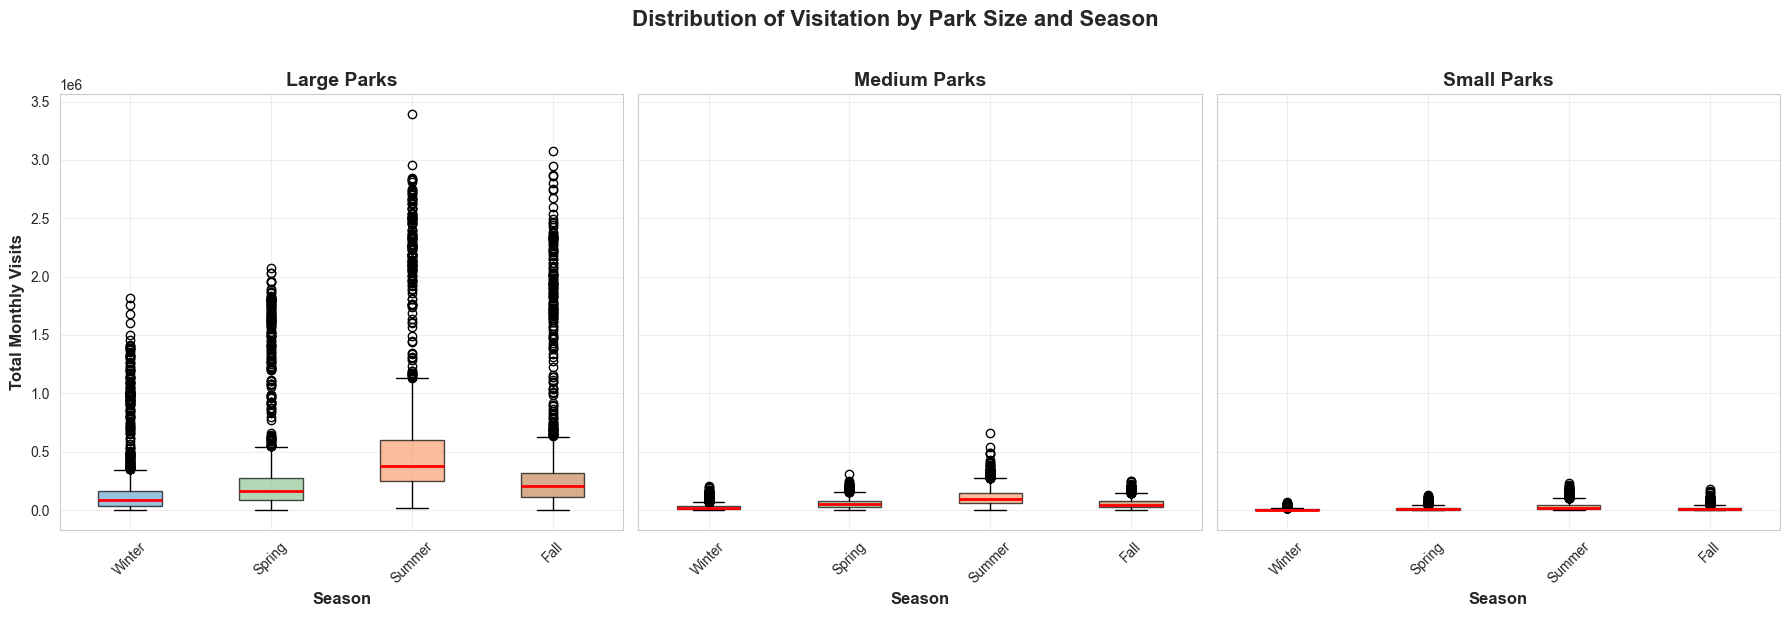

In [14]:
# Create box plots to show distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for idx, size in enumerate(size_order):
    size_data = df[df['SizeCategory'] == size]
    
    # Prepare data for box plot
    season_data = [size_data[size_data['Season'] == season]['TotalVisits'].values 
                   for season in season_order]
    
    bp = axes[idx].boxplot(season_data, labels=season_order, patch_artist=True,
                            medianprops=dict(color='red', linewidth=2))
    
    # Color the boxes by season
    for patch, season in zip(bp['boxes'], season_order):
        patch.set_facecolor(season_colors[season])
        patch.set_alpha(0.7)
    
    axes[idx].set_title(f'{size} Parks', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Season', fontsize=12, fontweight='bold')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3)

axes[0].set_ylabel('Total Monthly Visits', fontsize=12, fontweight='bold')
fig.suptitle('Distribution of Visitation by Park Size and Season', 
             fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()


## 6. Summary Statistics


In [15]:
# Create comprehensive summary table
print("=" * 80)
print("SUMMARY STATISTICS BY CATEGORY")
print("=" * 80)

for size in size_order:
    print(f"\n{size.upper()} PARKS")
    print("-" * 80)
    size_summary = category_visits[category_visits['SizeCategory'] == size]
    
    for _, row in size_summary.iterrows():
        print(f"  {row['Season']:8s}: Avg Visits = {row['AvgVisits']:>12,.0f} | "
              f"Total Visits = {row['TotalVisits']:>15,.0f} | "
              f"Count = {row['Count']:>8,.0f}")


SUMMARY STATISTICS BY CATEGORY

LARGE PARKS
--------------------------------------------------------------------------------
  Winter  : Avg Visits =          nan | Total Visits =               0 | Count =        0
  Winter  : Avg Visits =          nan | Total Visits =               0 | Count =        0
  Winter  : Avg Visits =          nan | Total Visits =               0 | Count =        0
  Winter  : Avg Visits =      143,867 | Total Visits =     416,927,960 | Count =    2,898
  Winter  : Avg Visits =          nan | Total Visits =               0 | Count =        0
  Winter  : Avg Visits =          nan | Total Visits =               0 | Count =        0
  Winter  : Avg Visits =          nan | Total Visits =               0 | Count =        0
  Winter  : Avg Visits =          nan | Total Visits =               0 | Count =        0
  Winter  : Avg Visits =          nan | Total Visits =               0 | Count =        0
  Winter  : Avg Visits =          nan | Total Visits =           

In [16]:
# Show parks in each size category
print("\n" + "=" * 80)
print("SAMPLE PARKS IN EACH SIZE CATEGORY")
print("=" * 80)

for size in size_order:
    parks_in_category = park_totals[park_totals['SizeCategory'] == size].head(10)
    print(f"\n{size.upper()} PARKS (Top 10):")
    print("-" * 80)
    for idx, row in parks_in_category.iterrows():
        print(f"  {row['ParkName']:50s} {row['TotalVisitsAllTime']:>15,.0f} total visits")



SAMPLE PARKS IN EACH SIZE CATEGORY

LARGE PARKS (Top 10):
--------------------------------------------------------------------------------
  Great Smoky Mountains NP                               895,608,088 total visits
  Grand Canyon NP                                        200,411,274 total visits
  Hot Springs NP                                         182,281,349 total visits
  Yellowstone NP                                         178,095,620 total visits
  Grand Teton NP                                         174,776,122 total visits
  Olympic NP                                             173,106,570 total visits
  Yosemite NP                                            165,777,011 total visits
  Rocky Mountain NP                                      149,232,416 total visits
  Acadia NP                                              145,144,435 total visits
  Saguaro NP                                             133,499,258 total visits

MEDIUM PARKS (Top 10):
----------------

## 7. Key Insights


In [17]:
# Calculate and display key insights
print("=" * 80)
print("KEY INSIGHTS")
print("=" * 80)

# Find peak season for each size category
for size in size_order:
    size_data = category_visits[category_visits['SizeCategory'] == size]
    peak_season = size_data.loc[size_data['AvgVisits'].idxmax(), 'Season']
    peak_visits = size_data['AvgVisits'].max()
    low_season = size_data.loc[size_data['AvgVisits'].idxmin(), 'Season']
    low_visits = size_data['AvgVisits'].min()
    
    print(f"\n{size} Parks:")
    print(f"  Peak Season: {peak_season} ({peak_visits:,.0f} avg visits)")
    print(f"  Low Season: {low_season} ({low_visits:,.0f} avg visits)")
    print(f"  Seasonal Variation: {(peak_visits/low_visits - 1)*100:.1f}% increase from low to peak")

# Overall statistics
print("\nOverall Statistics:")
print(f"  Total park-months analyzed: {len(df):,}")
print(f"  Number of unique parks: {df['ParkName'].nunique()}")
print(f"  Year range: {df['Year'].min()} - {df['Year'].max()}")
print(f"  Total visitation (all time): {df['TotalVisits'].sum():,.0f}")


KEY INSIGHTS

Large Parks:
  Peak Season: Summer (501,085 avg visits)
  Low Season: Winter (143,867 avg visits)
  Seasonal Variation: 248.3% increase from low to peak

Medium Parks:
  Peak Season: Summer (112,909 avg visits)
  Low Season: Winter (31,539 avg visits)
  Seasonal Variation: 258.0% increase from low to peak

Small Parks:
  Peak Season: Summer (27,708 avg visits)
  Low Season: Winter (5,407 avg visits)
  Seasonal Variation: 412.4% increase from low to peak

Overall Statistics:
  Total park-months analyzed: 34,151
  Number of unique parks: 63
  Year range: 1979 - 2024
  Total visitation (all time): 4,337,238,529
